# <a id="table-of-contents"></a>Table of Contents

1. [Intraday Mean Reversion](#section1)
2. [Moving Average](#section2)
3. [OBV](#section3)


In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import warnings

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression

In [2]:
# Define the path to the Downloads folder and the file
downloads_folder = os.path.expanduser("~/Desktop")
file_name = "aaHistoricalData_1726248252859.csv" 
file_path = os.path.join(downloads_folder, file_name)

# Read the CSV file into a DataFrame
data = pd.read_csv(file_path)

In [3]:
# Convert 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Sort the DataFrame by date in ascending order
data = data.sort_values(by='Date', ascending=True)

print(data.head(3))

           Date  Close/Last     Volume    Open    High     Low
2515 2014-09-15     198.981   76350030  199.16  199.32  198.38
2514 2014-09-16     200.480  116039000  198.61  200.84  198.50
2513 2014-09-17     200.750  149647200  200.77  201.68  199.75


In [4]:
# Assuming 'data' is your existing DataFrame
data['Original_Index'] = data.index  # Add the Original_Index column to capture current index
print('''It will record the INDEX to make sure that future data manipulations don't force us to lose the order.''')

It will record the INDEX to make sure that future data manipulations don't force us to lose the order.


In [27]:
# Add new columns with the given calculations
data['High_minus_Open'] = (data['High'] - data['Open']) / ((data['Open'] + data['Close/Last']) / 2)
data['day_change'] = (data['Close/Last'] - data['Close/Last'].shift(1)) / data['Close/Last'].shift(1)

data['opening_gaps'] = (data['Open'] - data['Close/Last'].shift(1)) / ((data['Open'] + data['Close/Last']) / 2)


data['net_Intraday_Movement_Around_Open_Ratio'] = ((data['High'] - data['Open']) / ((data['Open'] + data['Close/Last']) / 2)) - ((data['Open'] - data['Low']) / ((data['Open'] + data['Close/Last']) / 2))
data['Intraday_Volatility'] = ((data['High'] - data['Open']) / ((data['Open'] + data['Close/Last']) / 2)) + ((data['Open'] - data['Low']) / ((data['Open'] + data['Close/Last']) / 2))

# Calculate day change adjusted for opening gap
data['day_change_adjusted_for_openning_gap'] = data['day_change'] - data['opening_gaps']


# Create moving average columns
data['MA_5'] = data['Open'].rolling(window=5).mean()
data['MA_14'] = data['Open'].rolling(window=14).mean()
data['MA_50'] = data['Open'].rolling(window=50).mean()


# Create lagged features comparing today's open to these moving averages
data['open_above_MA_5'] = (data['Open'] > data['MA_5']).astype(int)
data['open_above_MA_14'] = (data['Open'] > data['MA_14']).astype(int)
data['open_above_MA_50'] = (data['Open'] > data['MA_50']).astype(int)

data['MA_Crossover_Signal_5_14'] = (data['MA_5'] > data['MA_5']).astype(int)

# Create a binary indicator for whether yesterday's close was above or below the 5-day MA
data['yesterday_close_above_MA_5'] = (data['Close/Last'].shift(1) > data['MA_14']).astype(int)


In [29]:
# Shift 'High' and 'Low' columns by 1
data['High_shift'] = data['High'].shift(1)
data['Low_shift'] = data['Low'].shift(1)

# Define the opening gap with the condition
def calculate_opening_gaps(row):
    if row['Open'] > row['High_shift']:
        return (row['Open'] - row['High_shift']) / ((row['Open'] + row['Close/Last']) / 2)
    elif row['Open'] < row['Low_shift']:
        return (row['Open'] - row['Low_shift']) / ((row['Open'] + row['Close/Last']) / 2)
    else:
        return np.nan



# Apply the calculation function to each row
data['opening_gaps_2'] = data.apply(calculate_opening_gaps, axis=1)

# Drop the shifted columns if they're not needed
data.drop(columns=['High_shift', 'Low_shift'], inplace=True)

print(data[['Date', 'Open', 'High', 'Low', 'Close/Last', 'opening_gaps_2']])


           Date    Open      High     Low  Close/Last  opening_gaps_2
2515 2014-09-15  199.16  199.3200  198.38     198.981             NaN
2514 2014-09-16  198.61  200.8400  198.50     200.480             NaN
2513 2014-09-17  200.77  201.6800  199.75     200.750             NaN
2512 2014-09-18  201.36  201.8500  201.10     201.820             NaN
2511 2014-09-19  201.52  201.8990  200.29     200.700             NaN
...         ...     ...       ...     ...         ...             ...
9    2024-08-29  560.31  563.6800  557.18     558.350             NaN
8    2024-08-30  560.77  564.2000  557.14     563.680             NaN
7    2024-09-03  560.47  560.8100  549.51     552.080             NaN
6    2024-09-04  550.20  554.4300  549.46     550.950             NaN
5    2024-09-05  550.89  553.7995  547.10     549.610             NaN

[2511 rows x 6 columns]


# <a id="section4"></a> Opening Gaps and Intraday Volatility
[Back to Table of Contents](#table-of-contents)


# <a id="section3"></a> OBV


In [21]:
data['OBV'] = 0

# Initialize the first value of OBV
data.loc[0, 'OBV'] = data.loc[0, 'Volume']

# Calculate OBV
for i in range(1, len(data)):
    if data.loc[i, 'Close/Last'] > data.loc[i-1, 'Close/Last']:
        data.loc[i, 'OBV'] = data.loc[i-1, 'OBV'] + data.loc[i, 'Volume']
    elif data.loc[i, 'Close/Last'] < data.loc[i-1, 'Close/Last']:
        data.loc[i, 'OBV'] = data.loc[i-1, 'OBV'] - data.loc[i, 'Volume']
    else:
        data.loc[i, 'OBV'] = data.loc[i-1, 'OBV']

          Date  Close/Last         OBV
175 2024-01-02      472.65 -1720700740
174 2024-01-03      468.79 -1843708540
173 2024-01-04      467.28 -1947294440
172 2024-01-05      467.92 -1863062270
171 2024-01-08      474.60 -1776943360


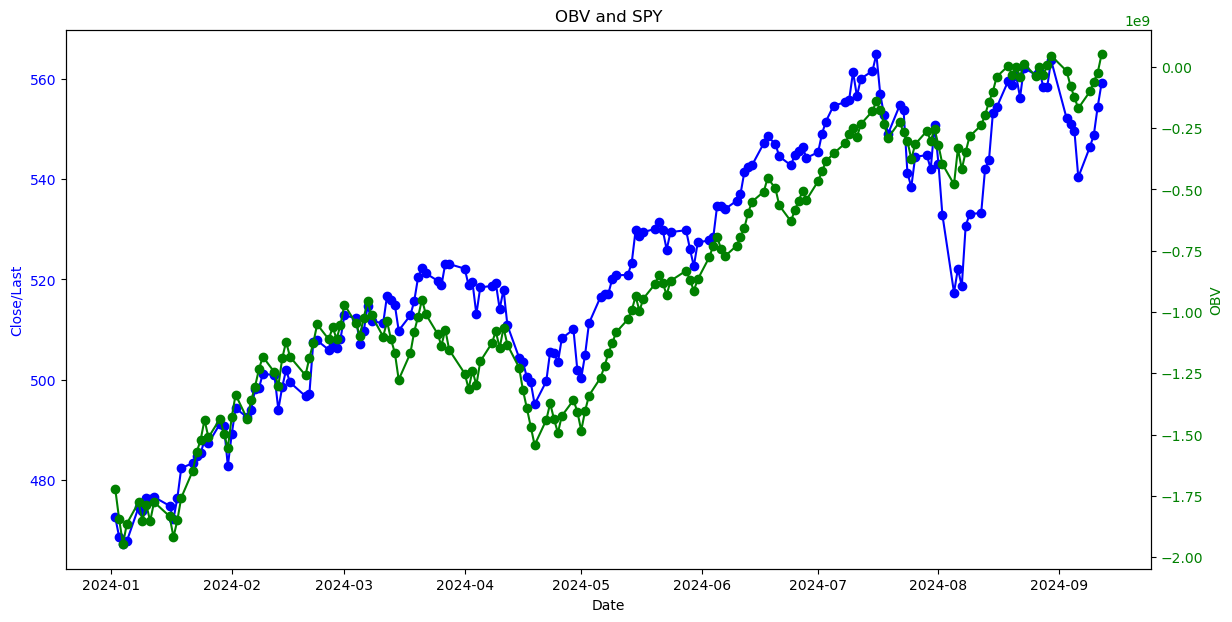


You're capturing the differences between OBV and SPY percentage changes over rolling windows, updating based on the maximum observed difference, and assessing 
retracements to set the OBV_SPY_metric.



In [22]:
# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Filter data to include only dates in the year 2024
data_2024 = data[data['Date'].dt.year == 2024]

# Display the first few rows to check the new DataFrame
print(data_2024[['Date', 'Close/Last', 'OBV']].head())

# Create dual-axis plot
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot Close/Last on the first y-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Close/Last', color='blue')
ax1.plot(data_2024['Date'], data_2024['Close/Last'], color='blue', marker='o')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for OBV
ax2 = ax1.twinx()
ax2.set_ylabel('OBV', color='green')
ax2.plot(data_2024['Date'], data_2024['OBV'], color='green', marker='o')
ax2.tick_params(axis='y', labelcolor='green')

# Add a title
plt.title('OBV and SPY')

# Show the plot
plt.show()


print('''
You're capturing the differences between OBV and SPY percentage changes over rolling windows, updating based on the maximum observed difference, and assessing 
retracements to set the OBV_SPY_metric.
''')

In [23]:
def calculate_obv_spy_metric_backward(data, initial_window_size=5, threshold=25):
    data['OBV_SPY_MAX_DIFF'] = np.nan  # Initialize the new independent variable column
    data['OBV_SPY_window_length'] = np.nan  # Initialize column for window length
    data['OBV_SPY_MAX_DIFF_INDEX'] = np.nan  # Initialize column to store index of max diff
    data['Max_Diff_Original_Index'] = np.nan  # Initialize new column to store index of max diff
    data['divergence_sign'] = np.nan  # Initialize column for divergence sign

    for i in range(initial_window_size, len(data)):  # Start from initial_window_size to ensure at least 5 loops
        max_diff = 0
        max_diff_index = data['Original_Index'].iloc[i]  # Initialize max_diff_index to current index
        j = 0
        obv_late = data['OBV'].iloc[i]  # Fixed to the current index in the outer loop
        spy_late = data['Close/Last'].iloc[i]  # Fixed to the current index in the outer loop

        while i - j >= 0:
            obv_early = data['OBV'].iloc[i-j]
            spy_early = data['Close/Last'].iloc[i-j]

            obv_pct_change = (obv_late - obv_early) / obv_early * 100
            spy_pct_change = (spy_late - spy_early) / spy_early * 100  

            obv_spy_pct_diff = obv_pct_change - spy_pct_change
            abs_current_diff = abs(obv_spy_pct_diff)

            # Determine divergence type
            if obv_spy_pct_diff >= 0:
                data.at[i, 'divergence_sign'] = "Positive_Divergence"
            elif obv_spy_pct_diff < 0: 
                data.at[i, 'divergence_sign'] = "Negative_Divergence"

            if abs_current_diff > max_diff:
                max_diff = abs_current_diff
                max_diff_index = data['Original_Index'].iloc[i-j]  # Update max_diff_index to Original_Index

            # Break condition
            if j >= initial_window_size and abs_current_diff <= 0.75 * max_diff:
                break

            j += 1  # Increment j by 1 to expand window backward

        data.at[i, 'OBV_SPY_MAX_DIFF'] = max_diff
        data.at[i, 'OBV_SPY_window_length'] = j
        data.at[i, 'Max_Diff_Original_Index'] = max_diff_index  # Store the index of the max diff

    return data

# Apply the function to the DataFrame
data = calculate_obv_spy_metric_backward(data)

# Drop rows with NaN values in OBV_SPY_MAX_DIFF
data.dropna(subset=['OBV_SPY_MAX_DIFF'], inplace=True)

# Print results to verify
print(data[['Date', 'Original_Index', 'OBV', 'OBV_SPY_MAX_DIFF', 'OBV_SPY_window_length', 'Max_Diff_Original_Index', 'divergence_sign']].head(5))


           Date  Original_Index          OBV  OBV_SPY_MAX_DIFF  \
2515 2014-09-15            2515 -18703866840        323.025182   
2514 2014-09-16            2514 -18627516810         88.756537   
2513 2014-09-17            2513 -18511477810        907.458388   
2512 2014-09-18            2512 -18361830610        504.591016   
2511 2014-09-19            2511 -18456246210       2381.263717   

      OBV_SPY_window_length  Max_Diff_Original_Index      divergence_sign  
2515                    5.0                      1.0  Negative_Divergence  
2514                    6.0                      4.0  Positive_Divergence  
2513                    8.0                      9.0  Positive_Divergence  
2512                    5.0                      7.0  Negative_Divergence  
2511                    6.0                      9.0  Positive_Divergence  


In [24]:
# Filter the DataFrame for 'OBV_SPY_window_length' values over 12
filtered_data = data[data['OBV_SPY_window_length'] > 9]

# Sort the filtered DataFrame by the 'Max_Diff_Original_Index' column
filtered_data = filtered_data.sort_values(by='Max_Diff_Original_Index')

# Create the "index_percent_change" column for 2% test
filtered_data['max_index_percent_change'] = filtered_data['Max_Diff_Original_Index'].pct_change() * 100

# Drop NaNs resulting from pct_change calculation
filtered_data = filtered_data.dropna(subset=['max_index_percent_change']).reset_index(drop=True)

# Initialize the "New_OBV_Trend" column with 0
filtered_data['New_OBV_Trend'] = 0

# Iterate through the DataFrame to set "New_OBV_Trend" based on both conditions
for i in range(1, len(filtered_data)):
    if abs(filtered_data['max_index_percent_change'].iloc[i]) >= .02 and abs(filtered_data['Max_Diff_Original_Index'].iloc[i] - filtered_data['Max_Diff_Original_Index'].iloc[i-1]) >= 5:
        filtered_data.at[i, 'New_OBV_Trend'] = 1

# Display the filtered data
print(filtered_data[['Max_Diff_Original_Index', 'Date', 'OBV_SPY_MAX_DIFF', 'OBV_SPY_window_length', 
                     'OBV', 'max_index_percent_change', 'divergence_sign','New_OBV_Trend']].head(3))

   Max_Diff_Original_Index       Date  OBV_SPY_MAX_DIFF  \
0                     27.0 2014-10-10         85.888987   
1                     56.0 2014-11-14         57.038713   
2                     56.0 2014-11-17         64.077202   

   OBV_SPY_window_length          OBV  max_index_percent_change  \
0                   11.0 -19016703490                  0.000000   
1                   15.0 -18110432060                107.407407   
2                   14.0 -18030121640                  0.000000   

       divergence_sign  New_OBV_Trend  
0  Negative_Divergence              0  
1  Negative_Divergence              1  
2  Negative_Divergence              0  


In [25]:
# Count the number of rows with value "1" in the New_OBV_Trend column
count_new_obv_trend = filtered_data['New_OBV_Trend'].sum()

# Count the number of negative divergences where New_OBV_Trend is 1
count_negative_divergence_sign = len(filtered_data[(filtered_data['divergence_sign'] == 'Negative_Divergence') & (filtered_data['New_OBV_Trend'] == 1)])

# Count the number of positive divergences where New_OBV_Trend is 1
count_positive_divergence_sign = len(filtered_data[(filtered_data['divergence_sign'] == 'Positive_Divergence') & (filtered_data['New_OBV_Trend'] == 1)])

print(f"Number of rows with value 1 in 'New_OBV_Trend': {count_new_obv_trend}")
print(f"Number of rows with negative divergence and new OBV trend: {count_negative_divergence_sign}")
print(f"Number of rows with positive divergence and new OBV trend: {count_positive_divergence_sign}")

Number of rows with value 1 in 'New_OBV_Trend': 103
Number of rows with negative divergence and new OBV trend: 69
Number of rows with positive divergence and new OBV trend: 34


In [26]:
# Define the number of future days for which we want the average close price
days_out = 3

# Create a new column that calculates the average close price over the next "days_out" days
data['avg_future_close'] = data['Close/Last'].shift(-days_out+1).rolling(window=days_out).mean()

print(data[['Date', 'Close/Last', 'avg_future_close']].head())


           Date  Close/Last  avg_future_close
2515 2014-09-15     198.981               NaN
2514 2014-09-16     200.480               NaN
2513 2014-09-17     200.750        201.090000
2512 2014-09-18     201.820        200.556667
2511 2014-09-19     200.700        199.286667


In [ ]:
# Calculate the sign of the opening gap using the shifted Close/Last column
data['sign_of_gap'] = data.apply(lambda row: 'positive_opening_gap' if row['Open'] > row['Prev_Close'] else 'negative_opening_gap', axis=1)

# Define the bins for opening_gaps
bins = np.linspace(data['opening_gaps'].min(), data['opening_gaps'].max(), num=15)  # Adjust the number of bins as needed

# Create a new column with binned opening_gaps
data['opening_gaps_bin'] = pd.cut(data['opening_gaps'], bins)

# Separate the positive and negative opening gaps
positive_gaps = data[data['sign_of_gap'] == 'positive_opening_gap']
negative_gaps = data[data['sign_of_gap'] == 'negative_opening_gap']

# Calculate the median and count for positive and negative gaps within each bin
positive_grouped = positive_gaps.groupby('opening_gaps_bin')['Intraday_Volatility'].agg(['median']).reset_index()
negative_grouped = negative_gaps.groupby('opening_gaps_bin')['Intraday_Volatility'].agg(['median']).reset_index()



# Merge the positive and negative grouped data back to the original data
data = pd.merge(data, positive_grouped, on='opening_gaps_bin', how='left', suffixes=('', '_positive'))
data = pd.merge(data, negative_grouped, on='opening_gaps_bin', how='left', suffixes=('', '_negative'))

# Calculate the difference between the median intraday volatilities for positive and negative gaps
data['median_volatility_difference'] = data['positive_median_volatility'] - data['negative_median_volatility']

# Drop NaNs in opening_gaps_bin (optional)
data = data.dropna(subset=['opening_gaps_bin'])

data.head()
